In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from tensorflow.examples.tutorials.mnist import input_data
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
"""
Compute the time elapsed
"""
def tic():
    global tic_time
    tic_time = time.time()
    
def toc():
    return time.time() - tic_time

In [3]:
"""
Load MNIST data
Return: all images and labels of train, validation, test dataset
"""
def load_data():
    mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)
    data = {
        'train_images': mnist.train.images,
        'train_labels': mnist.train.labels,
        'validation_images': mnist.validation.images,
        'validation_labels': mnist.validation.labels,
        'test_images': mnist.test.images,
        'test_labels': mnist.test.labels
    }
    return data

In [4]:
"""
Perform Data Augmentation
Variables: images format = NHWC, labels format = NC, times = times for augmentation
Return: augmented dataset
"""
def data_augmentation(images, labels, times):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
              rotation_range=15,
              zoom_range=0.1,
              width_shift_range=0.15,
              height_shift_range=0.15,
              data_format='channels_last'
    )
    counter = 0
    original_datasize = images.shape[0]
    for images_aug, labels_aug in datagen.flow(images, labels, batch_size=original_datasize, shuffle=False):
        if counter == times:
            break
        images = np.append(images, images_aug, axis=0)
        labels = np.append(labels, labels_aug, axis=0)
        counter += 1
    return images, labels

In [5]:
"""
Perform Data Shuffling
"""
def data_shuffling(images, labels):
    shuffle_array = np.random.permutation(images.shape[0])
    images = images[shuffle_array]
    labels = labels[shuffle_array]
    return images, labels

In [6]:
"""
Define the architecture of Convolutional Neural Networks
"""
def cnn_model(images, n_1, n_2, n_3, n_4, n_5, n_6, n_7, n_out, keep_prob_2, keep_prob_6, keep_prob_7, is_training):
    with tf.variable_scope('cnn_model'):
        A1 = tf.contrib.layers.conv2d(images, n_1, 5, scope='A1')
        A2 = tf.contrib.layers.conv2d(A1, n_2, 5, scope='A2')
        A2_maxpool = tf.contrib.layers.max_pool2d(A2, 2, scope='A2_maxpool')
        A2_dropout = tf.contrib.layers.dropout(A2_maxpool, keep_prob=keep_prob_2, is_training=is_training, scope='A2_dropout')
        A3 = tf.contrib.layers.conv2d(A2_dropout, n_3, 5, scope='A3')
        A4 = tf.contrib.layers.conv2d(A3, n_4, 5, scope='A4')
        A5 = tf.contrib.layers.conv2d(A4, n_5, 5, scope='A5')
        A6 = tf.contrib.layers.conv2d(A5, n_6, 5, scope='A6')
        A6_maxpool = tf.contrib.layers.max_pool2d(A6, 2, scope='A6_maxpool')
        A6_dropout = tf.contrib.layers.dropout(A6_maxpool, keep_prob=keep_prob_6, is_training=is_training, scope='A6_dropout')
        A6_flatten = tf.contrib.layers.flatten(A6_dropout, scope='A6_flatten')
        A7 = tf.contrib.layers.fully_connected(A6_flatten, n_7, scope='A7')
        A7_dropout = tf.contrib.layers.dropout(A7, keep_prob=keep_prob_7, is_training=is_training, scope='A7_dropout')
        Z_out = tf.contrib.layers.fully_connected(A7_dropout, n_out, activation_fn=None, scope='Z_out')
    return Z_out

In [7]:
"""
Define and Train Convolutional Neural Networks Model
Return: history of costs
"""
def mnist_cnn(hyperparams):
    tf.reset_default_graph()
    
    #Load, augment and shuffle data#
    data = load_data()
    data['train_images'], data['train_labels'] = data_augmentation(data['train_images'].reshape(-1, 28, 28, 1), data['train_labels'], hyperparams['augment_times'])
    data['validation_images'] = data['validation_images'].reshape(-1, 28, 28, 1)
    data['test_images'] = data['test_images'].reshape(-1, 28, 28, 1)
    data['train_images'], data['train_labels'] = data_shuffling(data['train_images'], data['train_labels'])
    
    #Hyperparameters settings and properties#
    learning_rate = hyperparams['learning_rate']
    decay_rate = hyperparams['decay_rate']
    decay_steps = hyperparams['decay_steps']
    epoch = hyperparams['epoch']
    keep_prob_2 = hyperparams['keep_prob_2']
    keep_prob_6 = hyperparams['keep_prob_6']
    keep_prob_7 = hyperparams['keep_prob_7']
    n_1 = hyperparams['n_1']
    n_2 = hyperparams['n_2']
    n_3 = hyperparams['n_3']
    n_4 = hyperparams['n_4']
    n_5 = hyperparams['n_5']
    n_6 = hyperparams['n_6']
    n_7 = hyperparams['n_7']
    n_out = hyperparams['n_out']
    batch_size = hyperparams['batch_size']
    train_data_size = data['train_images'].shape[0]
    validation_data_size = data['validation_images'].shape[0]
    test_data_size = data['test_images'].shape[0]
    image_size_H = 28
    image_size_W = 28
    label_size = data['train_labels'].shape[1]
    train_total_batches = np.ceil(train_data_size / batch_size).astype(np.int32)
    
    #Define placeholders#
    images_input = tf.placeholder(tf.float32, (None, image_size_H, image_size_W, 1), name='images_input')
    labels = tf.placeholder(tf.float32, (None, label_size), name='labels')
    is_training = tf.placeholder(tf.bool, name='is_training')
    
    #Define model#
    model_out = cnn_model(images_input, n_1, n_2, n_3, n_4, n_5, n_6, n_7, n_out, keep_prob_2, keep_prob_6, keep_prob_7, is_training)
    
    #Define Cost, Predictions, Comparisons and Accuracy#
    softmax_cost = tf.nn.softmax_cross_entropy_with_logits(logits=model_out, labels=labels, name='softmax_cost')
    cost_sum = tf.reduce_sum(softmax_cost, name='cost_sum')
    cost_mean = tf.reduce_mean(softmax_cost, name='cost_mean')
    predictions = tf.argmax(model_out, axis=-1, name='predictions')
    labels_sparse = tf.argmax(labels, axis=-1, name='labels_sparse')
    comparisons = tf.cast(tf.equal(predictions, labels_sparse, name='pred_labels_comparison_bool'), tf.float32, name='pred_labels_comparison_float32')
    accuracy_sum = tf.reduce_sum(comparisons, name='accuracy_sum')
    accuracy_mean = tf.reduce_mean(comparisons, name='accuracy_mean')
    
    #Compute decayed learning rate#
    global_step = tf.Variable(0, trainable=False, name='global_step', dtype=tf.int32)
    decayed_learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay_rate, staircase=False, name='decayed_learning_rate')
    
    #Define optimizer#
    opt_minimize = tf.train.AdamOptimizer(learning_rate=decayed_learning_rate, name='optimizer').minimize(cost_mean, global_step=global_step, name='opt_minimize')
    
    #Training#
    costs_history = {
        'train_cost_iter': [],
        'validation_cost_iter': []
    }
    accuracies_history = {
        'train_acc_iter': [],
        'validation_acc_iter': []
    }
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(epoch):
            tic()
            
            #Reset the accumulators#
            train_cost_epoch = 0.
            train_acc_epoch = 0.
            validation_cost_epoch = 0.
            validation_acc_epoch = 0.
            for j in range(train_total_batches):
                index_front = j * batch_size
                index_end = (j + 1) * batch_size if (j + 1) * batch_size < train_data_size else train_data_size
                images_batch = data['train_images'][index_front:index_end]
                labels_batch = data['train_labels'][index_front:index_end]
                current_batch_size = index_end - index_front
                
                #Update parameters of the model#
                _, train_cost_iter, train_acc_iter = sess.run([opt_minimize, cost_sum, accuracy_sum], feed_dict={images_input:images_batch, labels:labels_batch, is_training:True})
                
                #Run on validation set#
                validation_cost_mean_iter, validation_acc_mean_iter = sess.run([cost_mean, accuracy_mean], feed_dict={images_input:data['validation_images'], labels:data['validation_labels'], is_training:False})
                
                #Compute and save the average(likely) costs and accuracies#
                train_cost_epoch += train_cost_iter / train_data_size
                train_acc_epoch += train_acc_iter / train_data_size
                train_cost_mean_iter = train_cost_iter / current_batch_size
                train_acc_mean_iter = train_acc_iter / current_batch_size
                costs_history['train_cost_iter'].append(train_cost_mean_iter)
                costs_history['validation_cost_iter'].append(validation_cost_mean_iter)
                accuracies_history['train_acc_iter'].append(train_acc_mean_iter)
                accuracies_history['validation_acc_iter'].append(validation_acc_mean_iter)
                
            #Print the state every epoch#
            print('Epoch {}/{} Time Elapsed: {:.2f}s'.format(i + 1, epoch, toc()))
            print('Training Cost: {:.8f} Validation Cost: {:.8f} Training Accuracy: {:.4f} Validation Accuracy: {:.4f}'.format(train_cost_epoch, costs_history['validation_cost_iter'][-1], train_acc_epoch, accuracies_history['validation_acc_iter'][-1]))
        
        #Print the accuracy of running on test set#
        test_acc = sess.run(accuracy_mean, feed_dict={images_input:data['test_images'], labels:data['test_labels'], is_training:False})
        print('Testing Accuracy: {:.4f}'.format(test_acc))
    return costs_history, accuracies_history

In [8]:
"""
Show graphs of costs
"""
def show_costs_graphs(costs_history, ewma_span=10):
    plt.figure(figsize=(20, 10))
    plt.ylabel('Cost')
    plt.xlabel('Iteration')
    plt.title('Cost - Iteration')
    plt.plot(costs_history['train_cost_iter'], 'b-', alpha=0.3, label='Training Cost')
    plt.plot(costs_history['validation_cost_iter'], 'r-', alpha=0.3, label='Validation Cost')
    ewma_train_cost_iter = pd.stats.moments.ewma(np.array(costs_history['train_cost_iter']), span=ewma_span)
    plt.plot(ewma_train_cost_iter, 'b-', label='Training Cost EWMA')
    ewma_val_cost_iter = pd.stats.moments.ewma(np.array(costs_history['validation_cost_iter']), span=ewma_span)
    plt.plot(ewma_val_cost_iter, 'r-', label='Validation Cost EWMA')
    plt.legend(loc='best')
    plt.show()

In [9]:
"""
Show graphs of accuracies
"""
def show_accs_graphs(accuracies_history, ewma_span=10):
    plt.figure(figsize=(20, 10))
    plt.ylabel('Accuracy')
    plt.xlabel('Iteration')
    plt.title('Accuracy - Iteration')
    plt.plot(accuracies_history['train_acc_iter'], 'b-', alpha=0.3, label='Training Accuracy')
    plt.plot(accuracies_history['validation_acc_iter'], 'r-', alpha=0.3, label='Validation Accuracy')
    ewma_train_cost_iter = pd.stats.moments.ewma(np.array(accuracies_history['train_acc_iter']), span=ewma_span)
    plt.plot(ewma_train_cost_iter, 'b-', label='Training Accuracy EWMA')
    ewma_val_cost_iter = pd.stats.moments.ewma(np.array(accuracies_history['validation_acc_iter']), span=ewma_span)
    plt.plot(ewma_val_cost_iter, 'r-', label='Validation Accuracy EWMA')
    plt.legend(loc='best')
    plt.show()

In [10]:
"""
Define the hyperparameters
"""
hyperparams={
    'learning_rate': 0.001,
    'decay_rate': 0.95,
    'decay_steps': 2149,
    'epoch': 100,
    'keep_prob_2': 0.75,
    'keep_prob_6': 0.75,
    'keep_prob_7': 0.5,
    'n_1': 32,
    'n_2': 32,
    'n_3': 64,
    'n_4': 64,
    'n_5': 64,
    'n_6': 64,
    'n_7': 512,
    'n_out': 10,
    'batch_size': 128,
    'augment_times': 4
}
costs_history, accuracies_history = mnist_cnn(hyperparams)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch 1/100 Time Elapsed: 294.05s
Training Cost: 0.12889634 Validation Cost: 0.03368463 Training Accuracy: 0.9601 Validation Accuracy: 0.9920
Epoch 2/100 Time Elapsed: 292.26s
Training Cost: 0.04429089 Validation Cost: 0.02650260 Training Accuracy: 0.9874 Validation Accuracy: 0.9920
Epoch 3/100 Time Elapsed: 292.44s
Training Cost: 0.03369139 Validation Cost: 0.02391800 Training Accuracy: 0.9902 Validation Accuracy: 0.9934
Epoch 4/100 Time Elapsed: 292.41s
Training Cost: 0.02706418 Validation Cost: 0.01797147 Training Accuracy: 0.9920 Validation Accuracy: 0.9956
Epoch 5/100 Time Elapsed: 292.25s
Training Cost: 0.02275490 Validation Cost: 0.02230492 Training Accuracy: 0.9933 Validation Accuracy: 0.9932
Epoch 6/100 Time Elapsed: 292.22s
Training Cost: 0.01932709 Validation Cost: 0.01345814 Training

Epoch 57/100 Time Elapsed: 292.04s
Training Cost: 0.00033604 Validation Cost: 0.03396787 Training Accuracy: 0.9999 Validation Accuracy: 0.9970
Epoch 58/100 Time Elapsed: 292.36s
Training Cost: 0.00023813 Validation Cost: 0.03262033 Training Accuracy: 0.9999 Validation Accuracy: 0.9976
Epoch 59/100 Time Elapsed: 291.97s
Training Cost: 0.00027836 Validation Cost: 0.03665658 Training Accuracy: 0.9999 Validation Accuracy: 0.9976
Epoch 60/100 Time Elapsed: 292.16s
Training Cost: 0.00022082 Validation Cost: 0.02727470 Training Accuracy: 0.9999 Validation Accuracy: 0.9972
Epoch 61/100 Time Elapsed: 292.16s
Training Cost: 0.00033793 Validation Cost: 0.03275728 Training Accuracy: 0.9999 Validation Accuracy: 0.9966
Epoch 62/100 Time Elapsed: 292.14s
Training Cost: 0.00028809 Validation Cost: 0.03303706 Training Accuracy: 0.9999 Validation Accuracy: 0.9974
Epoch 63/100 Time Elapsed: 292.40s
Training Cost: 0.00014588 Validation Cost: 0.03477940 Training Accuracy: 0.9999 Validation Accuracy: 0.9970

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  del sys.path[0]


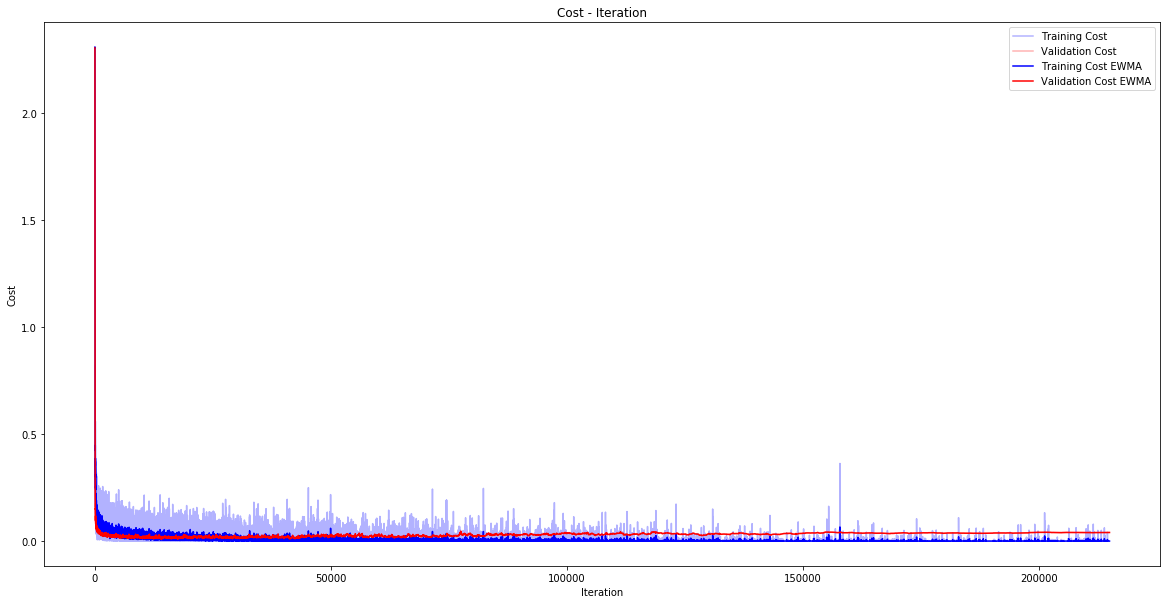

In [11]:
show_costs_graphs(costs_history)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  del sys.path[0]


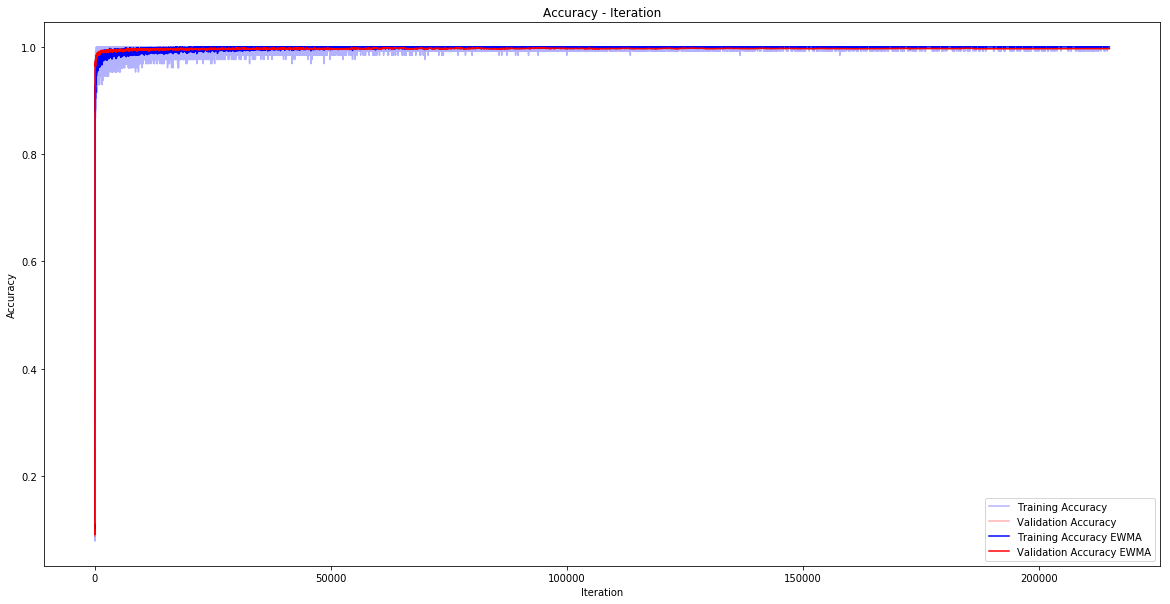

In [12]:
show_accs_graphs(accuracies_history)